# PRML : Polynomial Curve Fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import unicode_literals, print_function
import six
import sys
import os
import math
import datetime as dt
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-whitegrid')

In [2]:
sys.version

'3.6.0 |Anaconda 4.3.0 (x86_64)| (default, Dec 23 2016, 13:19:00) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## generate sample dataset

In [3]:
def make_truth_data(func=lambda x: x):
    xs = np.linspace(0, 1, num=50, endpoint=True)
    ts = func(xs)
    return xs, ts

def make_observed_data(func=lambda x: x, std=0.1):
    xs = np.linspace(0, 1, num=10, endpoint=True)
    ts = func(xs) + np.random.normal(0, std, xs.size)
    return xs, ts

def sin(x):
    return np.sin(2*np.pi*x)

#def step(x):
#    return 1.0 if x >= 0.5 and x <= 1.0 else 0.0

xs_truth, ts_truth = make_truth_data(np.vectorize(sin))
xs_observ, ts_observ = make_observed_data(np.vectorize(sin), std=0.2)

In [4]:
def plot_sample(ax, xs_truth, ys_truth, xs_observ, ts_observ):
    ax.plot(xs_truth, ts_truth, label='truth')
    ax.scatter(xs_observ, ts_observ, color='green', marker='o', label='observation')
    ax.set_xlim(np.min(xs_truth), np.max(xs_truth))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.legend()
    return ax

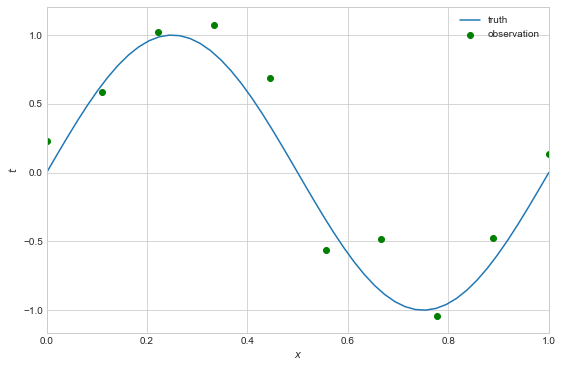

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)

## design matrix

ここでの基底関数は $\phi_{i}(x) = x^{i}$ とする

In [6]:
def poly_features(xs, m=1):
    # formula (3.16)
    return np.asarray([np.power(xs, i) for i in six.moves.range(m+1)]).transpose()

In [7]:
poly_features(xs_observ, m=3)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.11111111,  0.01234568,  0.00137174],
       [ 1.        ,  0.22222222,  0.04938272,  0.01097394],
       [ 1.        ,  0.33333333,  0.11111111,  0.03703704],
       [ 1.        ,  0.44444444,  0.19753086,  0.0877915 ],
       [ 1.        ,  0.55555556,  0.30864198,  0.17146776],
       [ 1.        ,  0.66666667,  0.44444444,  0.2962963 ],
       [ 1.        ,  0.77777778,  0.60493827,  0.47050754],
       [ 1.        ,  0.88888889,  0.79012346,  0.70233196],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

In [8]:
def plot_prediction(ax, ys_pred, ys_std):
    ax.plot(xs_truth, ys_pred, color='red', label='mean of predictive distribution')
    ax.fill_between(xs_truth, ys_pred-ys_std, ys_pred+ys_std,
                      color='pink', alpha=0.5, label='standard diviation of predictive distribution')
    ax.legend()
    return ax

## maximum likelihood estimation

In [9]:
class MaximumLikelihoodRegression():
    def __init__(self, basis_function=lambda x: x, m=1):
        self.basis_function = basis_function
        self.m = m
        
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.34) or (3.15)
        self.w_ml = np.linalg.inv(phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.21)
        self.std_ml = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_ml), 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_ml)
        return ys, self.std_ml

ys =  [ 0.07292379  0.27318413  0.44860542  0.60024585  0.7291636   0.83641686
  0.92306379  0.99016259  1.03877144  1.06994853  1.08475202  1.08424011
  1.06947097  1.0415028   1.00139377  0.95020206  0.88898586  0.81880334
  0.7407127   0.65577211  0.56503976  0.46957382  0.37043248  0.26867393
  0.16535634  0.0615379  -0.04172322 -0.14336882 -0.24234073 -0.33758077
 -0.42803075 -0.51263249 -0.5903278  -0.66005851 -0.72076644 -0.77139339
 -0.8108812  -0.83817167 -0.85220662 -0.85192788 -0.83627726 -0.80419657
 -0.75462764 -0.68651228 -0.59879232 -0.49040956 -0.36030583 -0.20742294
 -0.03070272  0.17091303]
std =  0.121435708851


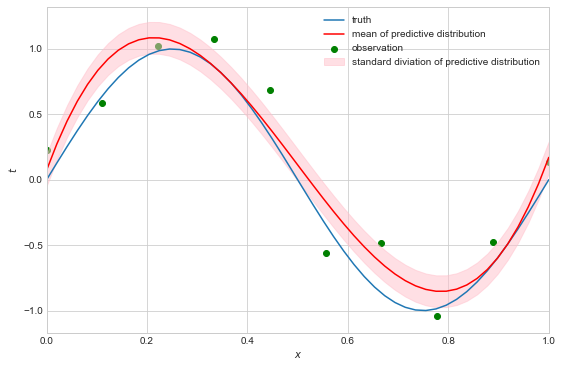

In [10]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きすぎるとover fittingが発生
- 分散も非常に小さい (high bias)

ys =  [ 0.22670382 -1.67975111 -1.85346568 -1.24322238 -0.41707951  0.32202189
  0.84683163  1.13832923  1.23644738  1.20561161  1.11211864  1.01074515
  0.9383262   0.9123681   0.93306528  0.98737253  1.05404534  1.10880002
  1.12896272  1.09717251  1.00387767  0.84851695  0.63940822  0.39247644
  0.12903997 -0.12705962 -0.35265512 -0.52842679 -0.6416986  -0.68852584
 -0.67478493 -0.6160403  -0.53604931 -0.4638734  -0.42969305 -0.45957474
 -0.56961095 -0.760048   -1.01023273 -1.27544629 -1.48695267 -1.55687019
 -1.38977702 -0.90328571 -0.06016756  1.08502458  2.3214976   3.196175
  2.9018885   0.13516902]
std =  1.22648225471e-08


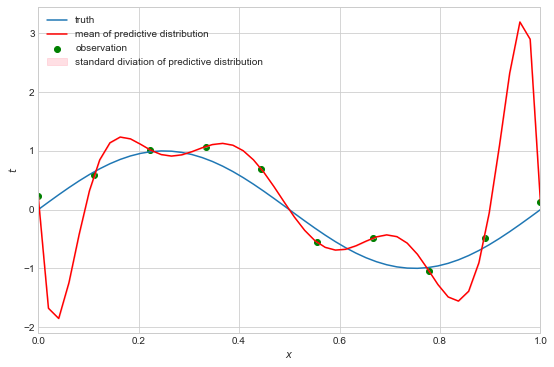

In [11]:
model = MaximumLikelihoodRegression(basis_function=poly_features, m=9)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## maximum posterior estimation

結果としては正則化最小二乗法 (§3.1.4) と同様らしいのでその通り実装 (これで合っている?)

In [12]:
class MaximumPosteriorRegression():
    def __init__(self, basis_function=lambda x: x, m=1, lmd=1):
        self.basis_function = basis_function
        self.m = m
        self.lmd = lmd
    
    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.28)
        self.w_map = np.linalg.inv(self.lmd * np.identity(phis.shape[1]) + phis.T.dot(phis)).dot(phis.T).dot(ts)
        # formula (3.29) or (1.67)
        self.std_map = (1./phis.shape[1]) * np.sum(np.power(ts - phis.dot(model.w_map), 2)) \
                            + (self.lmd/2.) * np.sum(np.power(self.w_map, 2))
        
    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.31) or (1.1)
        ys = phis.dot(self.w_map)
        return ys, self.std_map

ys =  [ 0.38893822  0.49776423  0.59128718  0.6701704   0.73507722  0.78667098
  0.82561501  0.85257264  0.8682072   0.87318201  0.86816042  0.85380576
  0.83078135  0.79975053  0.76137663  0.71632297  0.6652529   0.60882974
  0.54771683  0.48257749  0.41407506  0.34287287  0.26963425  0.19502253
  0.11970104  0.04433311 -0.03041791 -0.10388871 -0.17541596 -0.24433631
 -0.30998644 -0.37170302 -0.42882271 -0.48068219 -0.52661812 -0.56596717
 -0.59806601 -0.62225131 -0.63785974 -0.64422796 -0.64069265 -0.62659047
 -0.60125809 -0.56403218 -0.51424941 -0.45124645 -0.37435996 -0.28292662
 -0.17628309 -0.05376604]
std =  0.495168982038


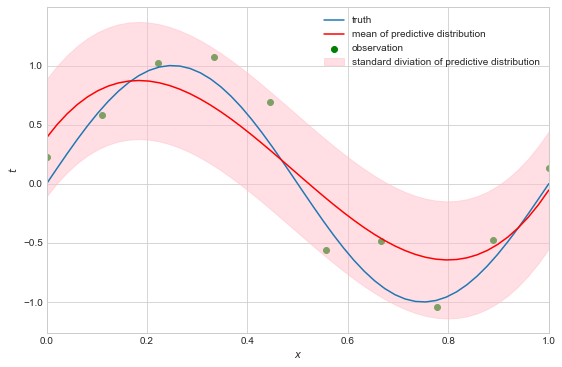

In [13]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=3, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

- データに対してオーダーが大きくても事前分布(≒正則化)の導入でover fittingを防ぐことができる
- ただし，ベイズ推定のようにパラメータの事後分布を求めている訳ではないので，outlierに弱い場合があるらしい
  - http://ibisforest.org/index.php?MAP推定

ys =  [ 0.27379433  0.37801691  0.47398468  0.56145093  0.64017886  0.70994422
  0.77053824  0.82177093  0.86347469  0.89550821  0.9177608   0.93015698
  0.93266141  0.92528409  0.90808591  0.88118425  0.84475897  0.79905828
  0.74440479  0.68120145  0.60993726  0.53119276  0.44564504  0.35407217
  0.25735685  0.15648917  0.05256808 -0.05319846 -0.15949501 -0.26490211
 -0.36790206 -0.46688715 -0.56017092 -0.64600265 -0.72258565 -0.78809955
 -0.84072736 -0.8786875  -0.90027152 -0.90388802 -0.88811325 -0.8517492
 -0.79388968 -0.71399512 -0.61197691 -0.48829192 -0.34404803 -0.18112159
 -0.00228763  0.18863633]
std =  0.153120860677


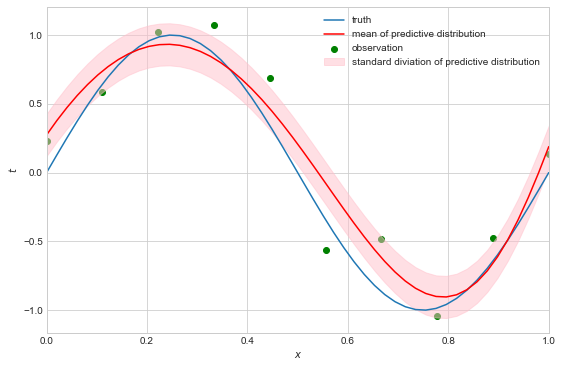

In [14]:
model = MaximumPosteriorRegression(basis_function=poly_features, m=9, lmd=1e-3)
model.fit(xs_observ, ts_observ)
ys_pred, ys_std = model.predict(xs_truth)
print('ys = ', ys_pred)
print('std = ', ys_std)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, ys_pred, ys_std)

## bayesian inference

In [15]:
class BayesianRegression():
    def __init__(self, basis_function=lambda x: x, m=1, alpha=1., beta=1.):
        self.basis_function = basis_function
        self.m = m
        self.alpha = alpha
        self.beta = beta

    def fit(self, xs, ts):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.53) or (1.72)
        var_inv = self.alpha * np.identity(phis.shape[1]) + self.beta * phis.T.dot(phis)
        self.var = np.linalg.inv(var_inv) 
        # formula (3.54) or (1.70)
        self.mean = self.beta * self.var.dot(phis.T.dot(ts))

    def predict(self, xs):
        phis = self.basis_function(xs, m=self.m)
        # formula (3.58)
        pred_mean = phis.dot(self.mean)
        # formula (3.59)
        pred_var = (1./self.beta) + np.sum(phis.dot(self.var.dot(phis.T)), axis=1)
        pred_std = np.sqrt(pred_var)
        return pred_mean, pred_std

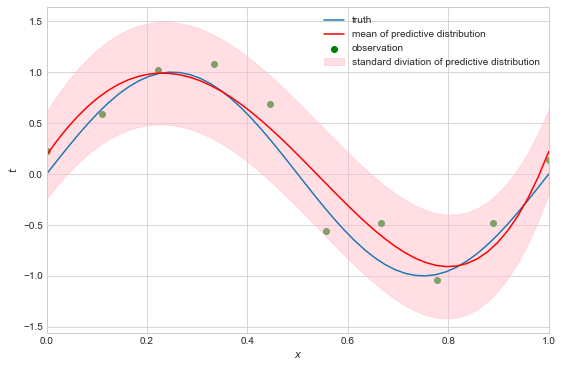

In [16]:
model = BayesianRegression(basis_function=poly_features, m=4, alpha=5e-3, beta=25)
model.fit(xs_observ, ts_observ)
pred_mean, pred_std = model.predict(xs_truth)

fig, axes = plt.subplots(figsize=(9,6))
axes = plot_sample(axes, xs_truth, ts_truth, xs_observ, ts_observ)
axes = plot_prediction(axes, pred_mean, pred_std)